In [511]:
%run ./sexism_data_preprocessing.ipynb

In [512]:
vectors = []

In [513]:
wordVectors = {}
with open("./glove.6B.300d.txt", 'rb') as f:
    for l in tqdm(f,total=400001):
        line = l.decode().split()
        word = line[0]
        
        vect = np.array(line[1:]).astype(np.float)
        wordVectors[word] = vect

In [514]:
wordVectors['_UNK'] = wordVectors['unk']
for word in word2idx:
    if word in wordVectors:
        vectors.append(wordVectors[word])
    else:
        vectors.append(wordVectors['_UNK'])

In [516]:
import numpy as np
import os
import random
from tqdm import tqdm
from sklearn.metrics import recall_score,precision_score,accuracy_score,confusion_matrix,f1_score

In [517]:
import matplotlib.pyplot as plt
%matplotlib inline

In [518]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms

In [519]:
from matplotlib import pyplot as plt
import seaborn as sns

## Model Arch

In [520]:
class LSTMSentenceEncoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,vectors,word2idx,cudaFlag,device):
        super(LSTMSentenceEncoder,self).__init__()
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.embedding = nn.Embedding.from_pretrained(vectors,freeze=False,padding_idx=word2idx['_PAD'])
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.word2idx = word2idx
        self.input_size = input_size
        self.cudaFlag = cudaFlag
        self.device = device
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigm = nn.Sigmoid()
        
    def forward(self,x):
        if self.cudaFlag:
#             h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True).to(self.device)
#             c0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True).to(self.device)
            h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(self.device)
            
            embs = self.embedding(x)
            embs = embs.view(x.size(0),-1,self.input_size).requires_grad_().to(self.device)
            
        else:
#             h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True)
#             c0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True)
            
            h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
        
            embs = self.embedding(x)
            embs = embs.view(x.size(0),-1,self.input_size)

        out,(hn,cn) = self.lstm(embs,(h0,c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [521]:
wordEmbs = torch.tensor(vectors)

### Model 1 - LSTM Sent Enc - with hidden dim size of 50

In [522]:
input_size = 300
hid_size = 50
output_size = 2
num_layers = 1

In [523]:
if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'
# device = 'cpu'
    
torch.manual_seed(np.random.randint(1000))
cudaFlag = torch.cuda.is_available()
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available(),device)
model = model.to(device)
model.float()

LSTMSentenceEncoder(
  (lstm): LSTM(300, 50, batch_first=True)
  (embedding): Embedding(6693, 300, padding_idx=0)
  (fc): Linear(in_features=50, out_features=2, bias=True)
  (sigm): Sigmoid()
)

In [524]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [525]:
count = 0
seq_dim = 10
num_epochs = 50

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label, sexism_type) in enumerate(trainLoader):
        
        text = text.view(-1, seq_dim, 1).to(device)
        labels=[]
        for j in range(len(sexism_label[0])):
            labels.append([sexism_label[0][j],sexism_label[1][j]])
        sexism_label = torch.FloatTensor(labels).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:    
            correct = 0
            total = 0

            allLabels = []
            allPreds = []
            
            for text,sexism_label, sexism_type in testLoader:
                text = Variable(text.view(-1, seq_dim, 1).to(device))
                labels=[]
                for j in range(len(sexism_label[0])):
                    labels.append([sexism_label[0][j],sexism_label[1][j]])
                sexism_label = torch.FloatTensor(labels).to(device)
                
                predicted = model(text)
                predicted =  torch.softmax(predicted,1)
                predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
                c_labels = torch.max(sexism_label, 1)[1].cpu().numpy().tolist()
                allLabels += (c_labels)
                allPreds += (predicted)

            acc = accuracy_score(allLabels,allPreds)
            f1 = f1_score(allLabels,allPreds,)
            prec = precision_score(allLabels,allPreds,)
            rec = recall_score(allLabels,allPreds,)
            
            train_losses_iterwise.append(np.mean(train_losses))
            recall_iterwise.append(rec)
            precision_iterwise.append(prec)
            accuracy_iterwise.append(acc)
            f1score_iterwise.append(f1)
            

In [526]:
iterNums = [i for i in range(len(train_losses_iterwise))]

Text(0.5,1,'Training Loss')

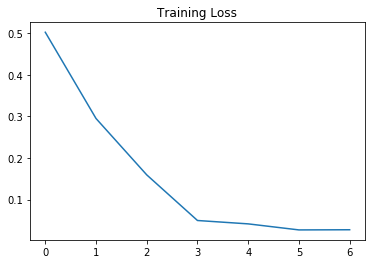

In [527]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])
plt.title("Training Loss")

Text(0.5,1,'Recall')

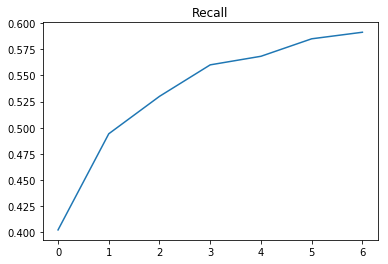

In [528]:
sns.lineplot(iterNums,[i.item() for i in recall_iterwise])
plt.title("Recall")

Text(0.5,1,'Precision')

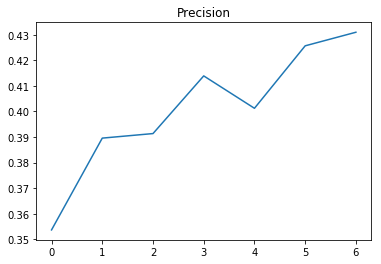

In [529]:
sns.lineplot(iterNums,[i.item() for i in precision_iterwise])
plt.title("Precision")

Text(0.5,1,'F1-score')

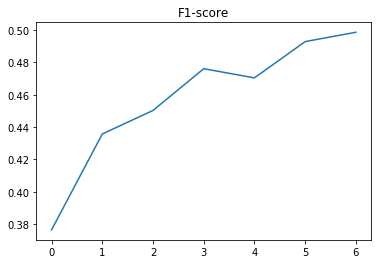

In [530]:
sns.lineplot(iterNums,[i.item() for i in f1score_iterwise])
plt.title("F1-score")

Text(0.5,1,'Accuracy')

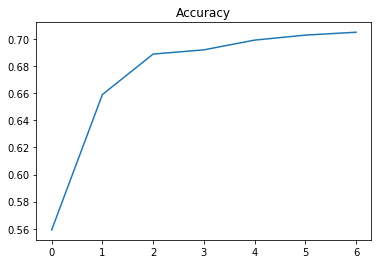

In [531]:
sns.lineplot(iterNums,[i.item() for i in accuracy_iterwise])
plt.title("Accuracy")

### Model 2 - LSTM Sent Enc - with hidden dim size of 100

In [532]:
input_size = 300
hid_size = 50
output_size = 2
num_layers = 1

In [533]:
torch.manual_seed(np.random.randint(1000))
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available(),device)
model = model.to(device)
model.float()

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [534]:
count = 0
seq_dim = 10
num_epochs = 100

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label, sexism_type) in enumerate(trainLoader):
        
        text = text.view(-1, seq_dim, 1).to(device)
        labels=[]
        for j in range(len(sexism_label[0])):
            labels.append([sexism_label[0][j],sexism_label[1][j]])
        sexism_label = torch.FloatTensor(labels).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:    
            correct = 0
            total = 0

            allLabels = []
            allPreds = []
            
            for text,sexism_label, sexism_type in testLoader:
                text = Variable(text.view(-1, seq_dim, 1).to(device))
                labels=[]
                for j in range(len(sexism_label[0])):
                    labels.append([sexism_label[0][j],sexism_label[1][j]])
                sexism_label = torch.FloatTensor(labels)
            
                
                predicted = model(text)
                predicted =  torch.softmax(predicted,1)
                predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
                c_labels = torch.max(sexism_label, 1)[1].cpu().numpy().tolist()
                allLabels += (c_labels)
                allPreds += (predicted)

            acc = accuracy_score(allLabels,allPreds)
            f1 = f1_score(allLabels,allPreds,)
            prec = precision_score(allLabels,allPreds,)
            rec = recall_score(allLabels,allPreds,)
            
            train_losses_iterwise.append(np.mean(train_losses))
            recall_iterwise.append(rec)
            precision_iterwise.append(prec)
            accuracy_iterwise.append(acc)
            f1score_iterwise.append(f1)

In [535]:
iterNums = [i for i in range(len(train_losses_iterwise))]

Text(0.5,1,'Training Loss')

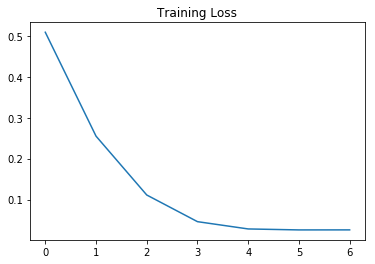

In [536]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])
plt.title("Training Loss")

Text(0.5,1,'Recall')

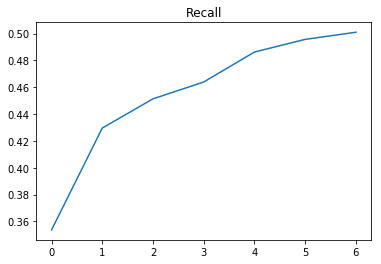

In [537]:
sns.lineplot(iterNums,[i.item() for i in recall_iterwise])
plt.title("Recall")

Text(0.5,1,'Precision')

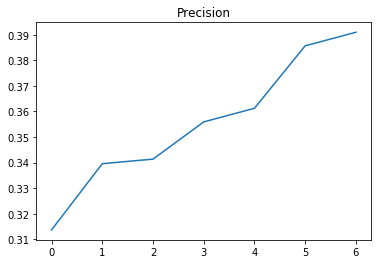

In [538]:
sns.lineplot(iterNums,[i.item() for i in precision_iterwise])
plt.title("Precision")

Text(0.5,1,'F1-score')

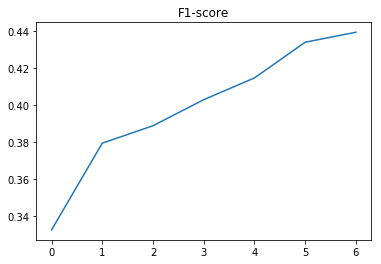

In [545]:
sns.lineplot(iterNums,[i.item() for i in f1score_iterwise])
plt.title("F1-score")

Text(0.5,1,'Accuracy')

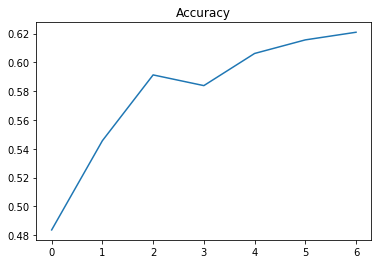

In [540]:
sns.lineplot(iterNums,[i.item() for i in accuracy_iterwise])
plt.title("Accuracy")

### Model 3 - LSTM Sent Enc - with hidden dim size of 100 and 2 Layers

In [541]:
input_size = 300
hid_size = 100
output_size = 2
num_layers = 2

In [542]:
model = LSTMSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available,device)
if torch.cuda.is_available():
    model = model.to(device)
model.float()

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [543]:
count = 0
seq_dim = 10
num_epochs = 100

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label, sexism_type) in enumerate(trainLoader):
        
        text = text.view(-1, seq_dim, 1).to(device)
        labels=[]
        for j in range(len(sexism_label[0])):
            labels.append([sexism_label[0][j],sexism_label[1][j]])
        sexism_label = torch.FloatTensor(labels).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:    
            correct = 0
            total = 0

            allLabels = []
            allPreds = []
            
            for text,sexism_label, sexism_type in testLoader:
                text = Variable(text.view(-1, seq_dim, 1).to(device))
                labels=[]
                for j in range(len(sexism_label[0])):
                    labels.append([sexism_label[0][j],sexism_label[1][j]])
                sexism_label = torch.FloatTensor(labels)
            
                
                predicted = model(text)
                predicted =  torch.softmax(predicted,1)
                predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
                c_labels = torch.max(sexism_label, 1)[1].cpu().numpy().tolist()
                allLabels += (c_labels)
                allPreds += (predicted)

            acc = accuracy_score(allLabels,allPreds)
            f1 = f1_score(allLabels,allPreds,)
            prec = precision_score(allLabels,allPreds,)
            rec = recall_score(allLabels,allPreds,)
            
            train_losses_iterwise.append(np.mean(train_losses))
            recall_iterwise.append(rec)
            precision_iterwise.append(prec)
            accuracy_iterwise.append(acc)
            f1score_iterwise.append(f1)

In [544]:
iterNums = [i for i in range(len(train_losses_iterwise))]

Text(0.5,1,'Training Loss')

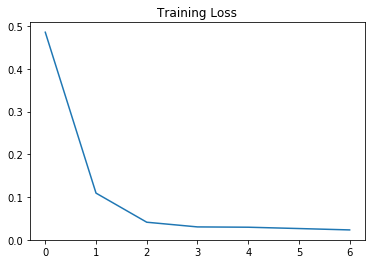

In [546]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])
plt.title("Training Loss")

Text(0.5,1,'Recall')

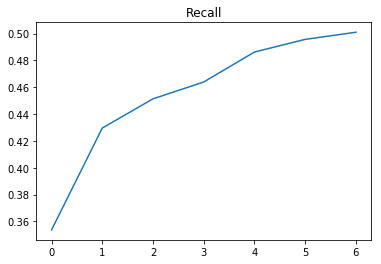

In [547]:
sns.lineplot(iterNums,[i.item() for i in recall_iterwise])
plt.title("Recall")

Text(0.5,1,'Precision')

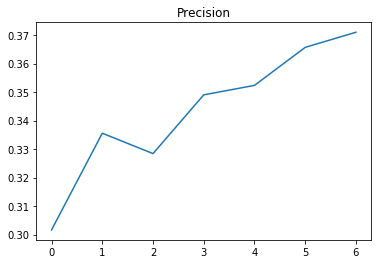

In [548]:
sns.lineplot(iterNums,[i.item() for i in precision_iterwise])
plt.title("Precision")


Text(0.5,1,'F1-score')

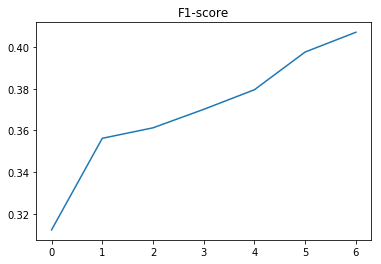

In [549]:
sns.lineplot(iterNums,[i.item() for i in f1score_iterwise])
plt.title("F1-score")

Text(0.5,1,'Accuracy')

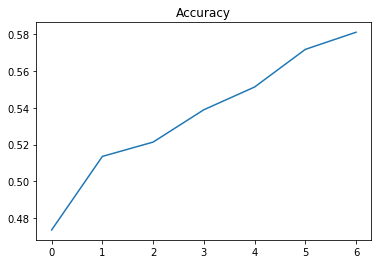

In [550]:
sns.lineplot(iterNums,[i.item() for i in accuracy_iterwise])
plt.title("Accuracy")

### Model 4 - RNN Sent Enc - with hidden dim size of 100 and 1 Layers

In [551]:
class RNNSentenceEncoder(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,vectors,word2idx,cudaFlag,device):
        super(RNNSentenceEncoder,self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vectors,freeze=False,padding_idx=word2idx['_PAD'])
        
        self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.word2idx = word2idx
        self.input_size = input_size
        self.cudaFlag = cudaFlag
        self.device = device
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self,x):
        if self.cudaFlag:
            h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True).to(self.device)
            
            embs = self.embedding(x)
            embs = embs.view(x.size(0),-1,self.input_size).requires_grad_().to(self.device)
            
        else:
            h0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size),requires_grad=True)
        
        embs = self.embedding(x)
        embs = embs.view(x.size(0),-1,self.input_size)

        out,hn = self.rnn(embs,h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

In [552]:
input_size = 300
hid_size = 100
output_size = 2
num_layers = 1

In [553]:
device = 'cuda:1'
cudaFlag = torch.cuda.is_available()
model = RNNSentenceEncoder(input_size,hid_size,output_size,num_layers,wordEmbs,word2idx,torch.cuda.is_available,device)
if torch.cuda.is_available():
    model = model.to(device)
model.float()

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [555]:
count = 0
seq_dim = 10
num_epochs = 100

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,sexism_label, sexism_type) in enumerate(trainLoader):
        
        text = text.view(-1, seq_dim, 1).to(device)
        labels=[]
        for j in range(len(sexism_label[0])):
            labels.append([sexism_label[0][j],sexism_label[1][j]])
        sexism_label = torch.FloatTensor(labels).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, sexism_label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0:    
            correct = 0
            total = 0

            allLabels = []
            allPreds = []
            
            for text,sexism_label, sexism_type in testLoader:
                text = Variable(text.view(-1, seq_dim, 1).to(device))
                labels=[]
                for j in range(len(sexism_label[0])):
                    labels.append([sexism_label[0][j],sexism_label[1][j]])
                sexism_label = torch.FloatTensor(labels)
            
                
                predicted = model(text)
                predicted =  torch.softmax(predicted,1)
                predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
                c_labels = torch.max(sexism_label, 1)[1].cpu().numpy().tolist()
                allLabels += (c_labels)
                allPreds += (predicted)

            acc = accuracy_score(allLabels,allPreds)
            f1 = f1_score(allLabels,allPreds,)
            prec = precision_score(allLabels,allPreds,)
            rec = recall_score(allLabels,allPreds,)
            
            train_losses_iterwise.append(np.mean(train_losses))
            recall_iterwise.append(rec)
            precision_iterwise.append(prec)
            accuracy_iterwise.append(acc)
            f1score_iterwise.append(f1)

In [558]:
iterNums = [i for i in range(len(train_losses_iterwise))]


Text(0.5,1,'Training Loss')

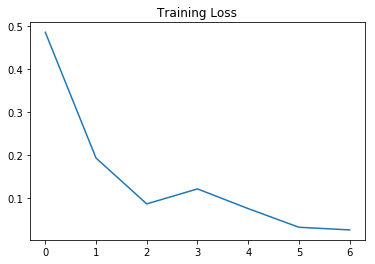

In [559]:
sns.lineplot(iterNums,[i.item() for i in train_losses_iterwise])
plt.title("Training Loss")

Text(0.5,1,'Recall')

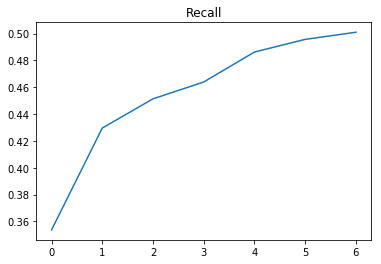

In [560]:
sns.lineplot(iterNums,[i.item() for i in recall_iterwise])
plt.title("Recall")

Text(0.5,1,'Precision')

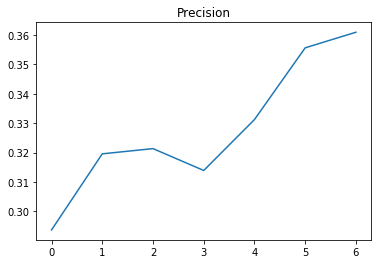

In [561]:
sns.lineplot(iterNums,[i.item() for i in precision_iterwise])
plt.title("Precision")

Text(0.5,1,'F1-score')

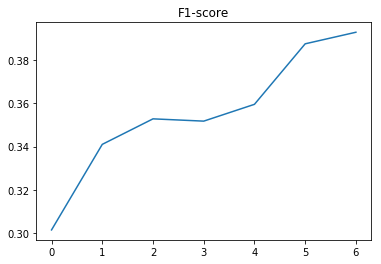

In [562]:
sns.lineplot(iterNums,[i.item() for i in f1score_iterwise])
plt.title("F1-score")

Text(0.5,1,'Accuracy')

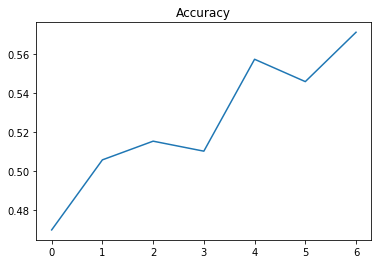

In [563]:
sns.lineplot(iterNums,[i.item() for i in accuracy_iterwise])
plt.title("Accuracy")